In [165]:
import pandas as pd
import numpy as np

from mamimo.time_utils import add_time_features

from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataframe

In [166]:
df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df['day'] = df.index # we will use this in our column transformer
df = df.drop(columns = ['fb_impressions', 'google_impressions', 'tt_impressions'])

In [167]:
# Sum clicks for each channel
df = df.eval('total_clicks = fb_clicks + tt_clicks + google_clicks')
df

,orders,total_sales,facebook,fb_clicks,google,google_clicks,tiktok,tt_clicks,day,total_clicks
Day,,,,,,,,,,
2021-07-01,10,414.85,257.01,129.0,1.17,20.0,0.00,0.0,2021-07-01,149.0
2021-07-02,6,229.95,250.30,150.0,0.84,7.0,0.00,0.0,2021-07-02,157.0
2021-07-03,10,459.89,248.59,129.0,0.72,6.0,0.00,0.0,2021-07-03,135.0
2021-07-04,17,508.36,258.05,119.0,0.07,5.0,0.00,0.0,2021-07-04,124.0
2021-07-05,13,399.88,257.47,142.0,0.38,16.0,0.00,0.0,2021-07-05,158.0
...,...,...,...,...,...,...,...,...,...,...
2023-08-20,294,13616.97,2148.53,1366.0,466.56,801.0,368.86,644.0,2023-08-20,2811.0
2023-08-21,356,15348.42,2210.01,1284.0,400.58,782.0,391.14,494.0,2023-08-21,2560.0
2023-08-22,150,6054.53,1335.84,839.0,289.46,619.0,218.61,398.0,2023-08-22,1856.0


# Split data

In [168]:
n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

y_train = train_df['total_clicks']
X_train = train_df.drop(columns = ['total_sales', 'orders', 'total_clicks', 'fb_clicks', 'google_clicks', 'tt_clicks'])

y_test = test_df['total_clicks']
X_test = test_df.drop(columns = ['total_sales', 'orders', 'total_clicks', 'fb_clicks', 'google_clicks', 'tt_clicks'])

# Custom Transformers

In [169]:
class AddWeekendsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        weekday_values = df.index.weekday
        df['fri_sat'] = ((weekday_values == 4) | (weekday_values == 5)).astype(int)
        return df[['fri_sat']]

In [170]:
class ReturnChannels(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        return df[['facebook', 'google', 'tiktok']]

# CT

In [171]:
time_features = ColumnTransformer([
     ('weekends_pipe', Pipeline([
            ('add_weekends', AddWeekendsTransformer())
     ]), ['day'])
])

channel_features = ColumnTransformer([
    ('channel_pipe', Pipeline([
        ('add_channels', ReturnChannels())
        ]), ['facebook', 'google','tiktok'])
])

scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['facebook','google','tiktok'])
    ])

# Optimization

In [172]:
# 0: Weekend
# 1: fb
# 2: google
# 3: tiktok

google_bound = 0

In [173]:
def linfunction(b, X):
    return b[0] + np.dot(X, b[1:])

def sumsquareerrors(b, X, y_true):
    y_pred = linfunction(b, X)
    return np.mean((y_true - y_pred)**2)

In [174]:
b0 = np.ones(5)

In [175]:
b0.shape

(5,)

In [176]:
X_train_scaled = pipe_df_minmax.drop(columns = ['spending_sum', 'total_clicks'])
y_train_clicks = pipe_df_minmax['total_clicks']

In [218]:
pipe_df_minmax['total_clicks']

day
2021-07-01     149.0
2021-07-02     157.0
2021-07-03     135.0
2021-07-04     124.0
2021-07-05     158.0
               ...  
2023-04-12    1430.0
2023-04-13    1337.0
2023-04-14    1101.0
2023-04-15    1017.0
2023-04-16    1366.0
Name: total_clicks, Length: 655, dtype: float64

In [220]:
y_pred = pd.DataFrame(y_pred).set_index(pipe_df_minmax.index)

,0
day,
2021-07-01,259.686760
2021-07-02,255.929115
2021-07-03,254.971280
2021-07-04,260.261982
2021-07-05,259.939291
...,...
2023-04-12,1088.362461
2023-04-13,1085.978268
2023-04-14,979.838128


In [199]:
b0

array([1., 1., 1., 1., 1.])

In [177]:
X_train_scaled.shape

(655, 4)

In [178]:
np.mean((linfunction(b0, X_train_scaled[0:10]) - linfunction(b0, X_train_scaled[10:20]))**2)

0.543250559629288

In [179]:
X_train_scaled[-10:].shape

(10, 4)

In [180]:
np.dot(X_train_scaled[-10:], b0[1:]) + b0[0]

array([3.35286364, 3.04556866, 2.26028628, 2.17831559, 2.10564614,
       2.06837266, 2.02087126, 2.88031997, 2.80541909, 2.09719919])

In [181]:
X_train_scaled[-10:]

,weekend,facebook,google,tiktok
day,,,,
2023-04-07,1.0,0.255499,0.776828,0.320537
2023-04-08,1.0,0.192035,0.558128,0.295406
2023-04-09,0.0,0.387251,0.623538,0.249497
2023-04-10,0.0,0.396681,0.532185,0.249450
2023-04-11,0.0,0.381564,0.474764,0.249319
2023-04-12,0.0,0.385817,0.433820,0.248736
2023-04-13,0.0,0.384440,0.387946,0.248486
2023-04-14,1.0,0.288527,0.334311,0.257482
2023-04-15,1.0,0.209924,0.310323,0.285172


In [249]:
google_bound = 5
bounds = ((None, None), (None, None), (0, None), (google_bound, None), (0, None))

In [250]:
from scipy.optimize import minimize

res = minimize(sumsquareerrors, x0=b0, args=(X_train_scaled, y_train_clicks), bounds=bounds)

In [251]:
res.x

array([ 139.42158475,  -77.72024552, 1279.41081961,    5.        ,
       1911.27351691])

In [286]:
r2_list = []
mse_list = []
mae_list = []
rmse_list = []

for i in range(1,2000):
    google_bound = i
    bounds = ((None, None), (None, None), (0, None), (google_bound, None), (0, None))
    res = minimize(sumsquareerrors, x0=b0, args=(X_train_scaled, y_train_clicks), bounds=bounds)
    res.x
    y_pred = linfunction(res.x, X_train_scaled)
    y_pred = pd.DataFrame(y_pred).set_index(pipe_df_minmax.index)
    y_pred = y_pred[0]
    y_true = y_train_clicks
    rss = ((y_pred - y_true)**2).sum()
    tss = ((y_true - np.mean(y_true))**2).sum()
    r2 = 1- (rss/tss)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared = False)
    mse = mean_squared_error(y_true, y_pred, squared = True)
    r2_list.append(r2)
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)

In [266]:
r2_list

[0.8594373471780127,
 0.8594119305862481,
 0.8593864006852976,
 0.8593607575153943,
 0.8593350010277364,
 0.8593091313043795,
 0.8592831482553382,
 0.8592570519319214,
 0.8592308422792014,
 0.8592045194014502]

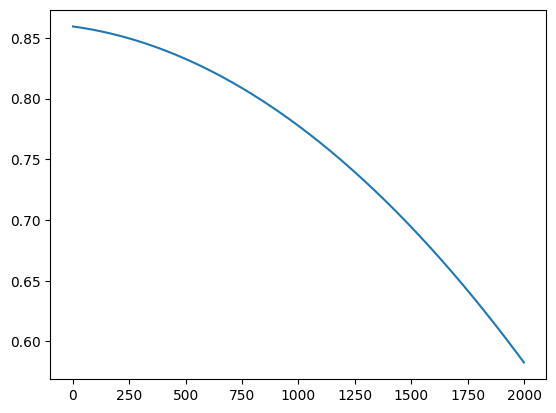

In [287]:
plt.plot(np.arange(1,2000), r2_list)

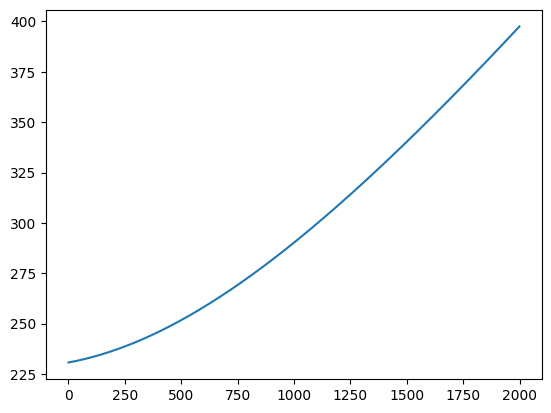

In [288]:
plt.plot(np.arange(1,2000), rmse_list)

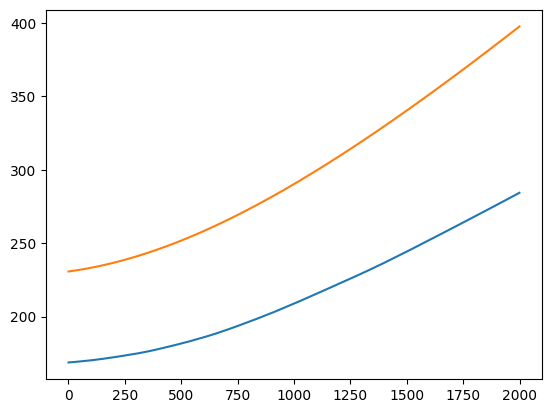

In [289]:
plt.plot(np.arange(1,2000), mae_list)
plt.plot(np.arange(1,2000), rmse_list)

# Scores

In [252]:
y_pred = linfunction(res.x, X_train_scaled)
y_pred = pd.DataFrame(y_pred).set_index(pipe_df_minmax.index)
y_pred = y_pred[0]

y_true = y_train_clicks

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared = False)
mse = mean_squared_error(y_true, y_pred, squared = True)
rss = ((y_pred - y_true)**2).sum()
tss = ((y_true - np.mean(y_true))**2).sum()
r2 = 1- (rss/tss)

f"R-squared: {r2}, MAE: {mae}, RMSE: {rmse}, MSE: {mse}"

'R-squared: 0.8593350010277364, MAE: 168.77196902939713, RMSE: 230.78210225207337, MSE: 53260.37871988645'

In [197]:
features = ['intercept', 'weekend', 'facebook', 'google', 'tiktok']
pd.Series(
    res.x,
    index=features
)

intercept     115.874067
weekend         0.000000
facebook     1284.799218
google          0.000000
tiktok       1913.931497
dtype: float64

In [189]:
X_train_scaled.google.describe()

count    655.000000
mean       0.162953
std        0.189648
min        0.000000
25%        0.005087
50%        0.114405
75%        0.288499
max        1.000000
Name: google, dtype: float64

In [188]:
train_df.google.describe()

count    655.000000
mean      78.324779
std       91.156360
min        0.000000
25%        2.445000
50%       54.990000
75%      138.670000
max      480.660000
Name: google, dtype: float64

# Pipeline

In [27]:
model = LinearRegression()

time_preprocessing = Pipeline([
    ('time_features', time_features)
])

channels = Pipeline([
    ('channel_features', channel_features)
])

union1 = FeatureUnion([
    ('time_preprocessing', time_preprocessing),
    ('channels', channels)
])

union2 = FeatureUnion([
    ('time_preprocessing', time_preprocessing),
    ('scaler', scaler)
])

pipeline = Pipeline([
    ('union1', union1),
    ('model', model)
])

pipeline_minmax = Pipeline([
    ('union2', union2),
    ('model', model)
])

# Linear Regression - No scaling

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('union1',
                 FeatureUnion(transformer_list=[('time_preprocessing',
                                                 Pipeline(steps=[('time_features',
                                                                  ColumnTransformer(transformers=[('weekends_pipe',
                                                                                                   Pipeline(steps=[('add_weekends',
                                                                                                                    AddWeekendsTransformer())]),
                                                                                                   ['day'])]))])),
                                                ('channels',
                                                 Pipeline(steps=[('channel_features',
                                                                  ColumnTransformer(transformers=[('channel_pipe',
                                                                                                   Pipeline(steps=[('add_channels',
                                                                                                                    ReturnChannels())]),
                                                                                                   ['facebook',
                                                                                                    'google',
                                                                                                    'tiktok'])]))]))])),
                ('model', LinearRegression())])

# Intercept + Coefficients

In [10]:
pipeline[-1].intercept_

144.6378477173514

In [11]:
features = ['weekend', 'facebook', 'google', 'tiktok']
pd.Series(
    pipeline[-1].coef_,
    index=features
)

weekend    -84.802133
facebook     0.573037
google      -0.463640
tiktok       2.401787
dtype: float64

## Pipeline Output

In [12]:
X_pipe = pd.DataFrame(pipeline[0].transform(X_train))
X_pipe.columns = ['weekend', 'facebook', 'google', 'tiktok']
X_pipe['spending_sum'] = X_pipe['facebook'] + X_pipe['google'] + X_pipe['tiktok']
X_pipe['day'] = train_df.index
X_pipe.set_index('day', inplace=True)
X_pipe

,weekend,facebook,google,tiktok,spending_sum
day,,,,,
2021-07-01,0.0,257.01,1.17,0.00,258.18
2021-07-02,1.0,250.30,0.84,0.00,251.14
2021-07-03,1.0,248.59,0.72,0.00,249.31
2021-07-04,0.0,258.05,0.07,0.00,258.12
2021-07-05,0.0,257.47,0.38,0.00,257.85
...,...,...,...,...,...
2023-04-12,0.0,885.33,208.52,209.03,1302.88
2023-04-13,0.0,882.17,186.47,208.82,1277.46
2023-04-14,1.0,662.08,160.69,216.38,1039.15


In [13]:
pipe_df = X_pipe.copy()
pipe_df['total_clicks'] = train_df['total_clicks']
pipe_df

,weekend,facebook,google,tiktok,spending_sum,total_clicks
day,,,,,,
2021-07-01,0.0,257.01,1.17,0.00,258.18,149.0
2021-07-02,1.0,250.30,0.84,0.00,251.14,157.0
2021-07-03,1.0,248.59,0.72,0.00,249.31,135.0
2021-07-04,0.0,258.05,0.07,0.00,258.12,124.0
2021-07-05,0.0,257.47,0.38,0.00,257.85,158.0
...,...,...,...,...,...,...
2023-04-12,0.0,885.33,208.52,209.03,1302.88,1430.0
2023-04-13,0.0,882.17,186.47,208.82,1277.46,1337.0
2023-04-14,1.0,662.08,160.69,216.38,1039.15,1101.0


# Scores

In [14]:
y_pred = pipeline.predict(X_train)
y_true = y_train

rmse = mean_squared_error(y_true, y_pred, squared = False)
mse = mean_squared_error(y_true, y_pred, squared = True)
mae = mean_absolute_error(y_true, y_pred)
r2 = pipeline.score(X_test, y_test)

f"R-squared: {r2}, MAE: {mae}, RMSE: {rmse}, MSE: {mse}"

'R-squared: 0.5688070039485994, MAE: 168.29542308810872, RMSE: 228.35694750702535, MSE: 52146.89547472633'

<Axes: xlabel='spending_sum', ylabel='total_clicks'>

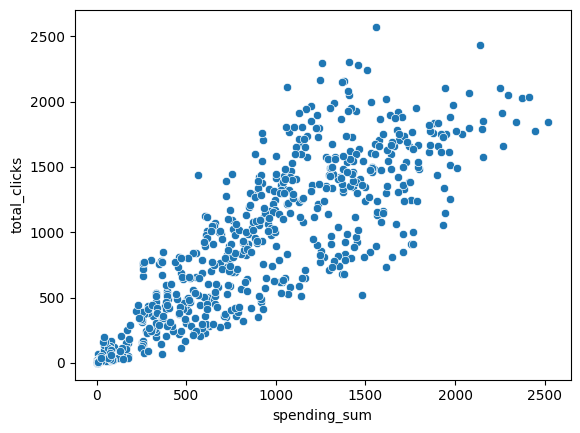

In [15]:
sns.scatterplot(data = pipe_df, x = 'spending_sum', y = 'total_clicks')

# OLS

In [16]:
model = smf.ols(formula='total_clicks ~ weekend+facebook+google+tiktok', data=pipe_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_clicks   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1017.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          4.24e-278
Time:                        14:18:54   Log-Likelihood:                -4486.7
No. Observations:                 655   AIC:                             8983.
Df Residuals:                     650   BIC:                             9006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    144.6378     17.313      8.354      0.000     110.641     178.635
weekend      -84.8021     19.897     -4.262      0.000    -123.873     -45.731
facebook       0.5730      0.023     24.502      0.000       0.527       0.619
google        -0.4636      0.127     -3.644      0.000      -0.713      -0.214
tiktok         2.4018      0.064     37.762      0.000       2.277       2.527
==============================================================================
Omnibus:                       61.416   Durbin-Watson:                   0.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.175
Skew:                           0.353   Prob(JB):                     1.04e-50
Kurtosis:                       5.817   Cond. No.                     1.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
model.pvalues[1:]

weekend      2.326111e-05
facebook     2.077798e-94
google       2.901377e-04
tiktok      4.747323e-166
dtype: float64

# Linear Regression - MinMax Scaling

In [18]:
pipeline_minmax.fit(X_train, y_train)

Pipeline(steps=[('union2',
                 FeatureUnion(transformer_list=[('time_preprocessing',
                                                 Pipeline(steps=[('time_features',
                                                                  ColumnTransformer(transformers=[('weekends_pipe',
                                                                                                   Pipeline(steps=[('add_weekends',
                                                                                                                    AddWeekendsTransformer())]),
                                                                                                   ['day'])]))])),
                                                ('scaler',
                                                 ColumnTransformer(transformers=[('minmax',
                                                                                  MinMaxScaler(),
                                                                                  ['facebook',
                                                                                   'google',
                                                                                   'tiktok'])]))])),
                ('model', LinearRegression())])

# Intercept + Coefficients

In [19]:
pipeline_minmax[-1].intercept_

144.6378477173521

In [20]:
features = ['weekend', 'facebook', 'google', 'tiktok']
pd.Series(
    pipeline_minmax[-1].coef_,
    index=features
)

weekend      -84.802133
facebook    1314.942671
google      -222.853218
tiktok      2018.389665
dtype: float64

## Pipeline Output

In [21]:
X_pipe_minmax = pd.DataFrame(pipeline_minmax[0].transform(X_train))
X_pipe_minmax.columns = ['weekend', 'facebook', 'google', 'tiktok']
X_pipe_minmax['spending_sum'] = X_pipe_minmax['facebook'] + X_pipe_minmax['google'] + X_pipe_minmax['tiktok']
X_pipe_minmax['day'] = train_df.index
X_pipe_minmax.set_index('day', inplace=True)
X_pipe_minmax

,weekend,facebook,google,tiktok,spending_sum
day,,,,,
2021-07-01,0.0,0.112002,0.002434,0.000000,0.114436
2021-07-02,1.0,0.109078,0.001748,0.000000,0.110826
2021-07-03,1.0,0.108333,0.001498,0.000000,0.109831
2021-07-04,0.0,0.112455,0.000146,0.000000,0.112601
2021-07-05,0.0,0.112203,0.000791,0.000000,0.112993
...,...,...,...,...,...
2023-04-12,0.0,0.385817,0.433820,0.248736,1.068373
2023-04-13,0.0,0.384440,0.387946,0.248486,1.020871
2023-04-14,1.0,0.288527,0.334311,0.257482,0.880320


In [22]:
pipe_df_minmax = X_pipe_minmax.copy()
pipe_df_minmax['total_clicks'] = train_df['total_clicks']
pipe_df_minmax

,weekend,facebook,google,tiktok,spending_sum,total_clicks
day,,,,,,
2021-07-01,0.0,0.112002,0.002434,0.000000,0.114436,149.0
2021-07-02,1.0,0.109078,0.001748,0.000000,0.110826,157.0
2021-07-03,1.0,0.108333,0.001498,0.000000,0.109831,135.0
2021-07-04,0.0,0.112455,0.000146,0.000000,0.112601,124.0
2021-07-05,0.0,0.112203,0.000791,0.000000,0.112993,158.0
...,...,...,...,...,...,...
2023-04-12,0.0,0.385817,0.433820,0.248736,1.068373,1430.0
2023-04-13,0.0,0.384440,0.387946,0.248486,1.020871,1337.0
2023-04-14,1.0,0.288527,0.334311,0.257482,0.880320,1101.0


# Scores

In [23]:
y_pred = pipeline_minmax.predict(X_train)
y_true = y_train

rmse = mean_squared_error(y_true, y_pred, squared = False)
mse = mean_squared_error(y_true, y_pred, squared = True)
mae = mean_absolute_error(y_true, y_pred)
r2 = pipeline_minmax.score(X_test, y_test)

f"R-squared: {r2}, MAE: {mae}, RMSE: {rmse}, MSE: {mse}"

'R-squared: 0.5688070039486002, MAE: 168.2954230881088, RMSE: 228.35694750702535, MSE: 52146.89547472633'

<Axes: xlabel='spending_sum', ylabel='total_clicks'>

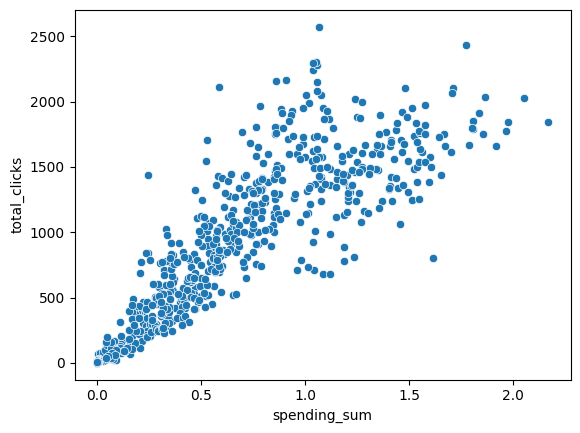

In [24]:
sns.scatterplot(data = pipe_df_minmax, x = 'spending_sum', y = 'total_clicks')

# OLS

In [25]:
model_minmax = smf.ols(formula='total_clicks ~ weekend+facebook+google+tiktok', data=pipe_df_minmax).fit()
model_minmax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_clicks   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1017.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          4.24e-278
Time:                        14:18:55   Log-Likelihood:                -4486.7
No. Observations:                 655   AIC:                             8983.
Df Residuals:                     650   BIC:                             9006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    144.6378     17.313      8.354      0.000     110.641     178.635
weekend      -84.8021     19.897     -4.262      0.000    -123.873     -45.731
facebook    1314.9427     53.667     24.502      0.000    1209.560    1420.325
google      -222.8532     61.160     -3.644      0.000    -342.949    -102.757
tiktok      2018.3897     53.450     37.762      0.000    1913.434    2123.346
==============================================================================
Omnibus:                       61.416   Durbin-Watson:                   0.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.175
Skew:                           0.353   Prob(JB):                     1.04e-50
Kurtosis:                       5.817   Cond. No.                         8.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
model_minmax.pvalues[1:]

weekend      2.326111e-05
facebook     2.077798e-94
google       2.901377e-04
tiktok      4.747323e-166
dtype: float64

In [29]:
train_df

,orders,total_sales,facebook,fb_clicks,google,google_clicks,tiktok,tt_clicks,day,total_clicks
Day,,,,,,,,,,
2021-07-01,10,414.85,257.01,129.0,1.17,20.0,0.00,0.0,2021-07-01,149.0
2021-07-02,6,229.95,250.30,150.0,0.84,7.0,0.00,0.0,2021-07-02,157.0
2021-07-03,10,459.89,248.59,129.0,0.72,6.0,0.00,0.0,2021-07-03,135.0
2021-07-04,17,508.36,258.05,119.0,0.07,5.0,0.00,0.0,2021-07-04,124.0
2021-07-05,13,399.88,257.47,142.0,0.38,16.0,0.00,0.0,2021-07-05,158.0
...,...,...,...,...,...,...,...,...,...,...
2023-04-12,83,3718.12,885.33,640.0,208.52,349.0,209.03,441.0,2023-04-12,1430.0
2023-04-13,75,2913.63,882.17,740.0,186.47,272.0,208.82,325.0,2023-04-13,1337.0
2023-04-14,53,1735.46,662.08,497.0,160.69,258.0,216.38,346.0,2023-04-14,1101.0


# Time Series

## Check Stationarity

In [34]:
from statsmodels.tsa.stattools import adfuller

clicks_adf = adfuller(df.total_clicks)[1]
fb_adf = adfuller(pipe_df_minmax.facebook)[1]
gg_adf = adfuller(pipe_df_minmax.google)[1] 
tt_adf = adfuller(pipe_df_minmax.tiktok)[1] 

f"Total Clicks ADF: {clicks_adf}, Facebook ADF: {fb_adf}, Google ADF: {gg_adf}, Tiktok ADF: {tt_adf}"

'Total Clicks ADF: 0.0020324002857303376, Facebook ADF: 0.0019783239166436856, Google ADF: 0.6267680385529537, Tiktok ADF: 0.05238247446221673'

## Total Clicks

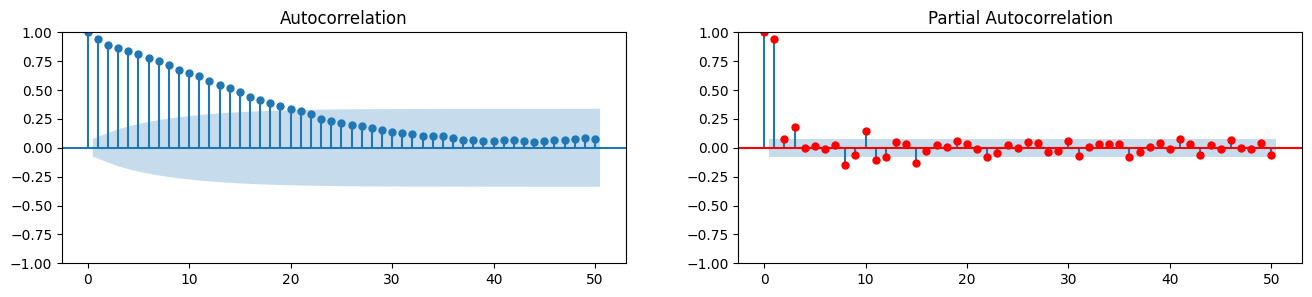

In [38]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(train_df['total_clicks'], lags=50, ax=axes[0]);
plot_pacf(train_df['total_clicks'], lags=50, ax=axes[1], color='r');

In [103]:
smodel = pm.auto_arima(train_df['total_clicks'],
                       start_p=1, max_p=5,
                       start_q=18, max_q=22,
                       seasonal=False,
                       trend = 'n',
                       trace=True)

# ARIMA(0,1,16)(0,0,0)[0], AIC=8803.987

Performing stepwise search to minimize aic
 ARIMA(1,1,18)(0,0,0)[0] intercept   : AIC=8809.017, Time=2.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8860.701, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8856.363, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8852.138, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8860.701, Time=0.01 sec
 ARIMA(0,1,18)(0,0,0)[0] intercept   : AIC=8807.106, Time=1.63 sec
 ARIMA(0,1,17)(0,0,0)[0] intercept   : AIC=8805.555, Time=1.17 sec
 ARIMA(0,1,16)(0,0,0)[0] intercept   : AIC=8803.987, Time=1.97 sec
 ARIMA(0,1,15)(0,0,0)[0] intercept   : AIC=8814.498, Time=1.71 sec
 ARIMA(1,1,16)(0,0,0)[0] intercept   : AIC=8805.609, Time=2.53 sec
 ARIMA(1,1,15)(0,0,0)[0] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,1,17)(0,0,0)[0] intercept   : AIC=8807.240, Time=2.16 sec
 ARIMA(0,1,16)(0,0,0)[0]             : AIC=8803.987, Time=1.88 sec

Best model:  ARIMA(0,1,16)(0,0,0)[0]          
Total fit time: 18.377 seconds


In [104]:
import pmdarima as pm
smodel = pm.auto_arima(train_df['total_clicks'],
                       start_p=1, max_p=5,
                       start_q=18, max_q=22,
                       seasonal=False,
                       trend = 't',
                       trace=True)

# ARIMA(0,1,16)(0,0,0)[0], AIC=8805.932

Performing stepwise search to minimize aic
 ARIMA(1,1,18)(0,0,0)[0] intercept   : AIC=8810.960, Time=3.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8862.678, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8858.339, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8854.132, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8862.678, Time=0.03 sec
 ARIMA(0,1,18)(0,0,0)[0] intercept   : AIC=8809.050, Time=1.98 sec
 ARIMA(0,1,17)(0,0,0)[0] intercept   : AIC=8807.487, Time=1.50 sec
 ARIMA(0,1,16)(0,0,0)[0] intercept   : AIC=8805.932, Time=3.26 sec
 ARIMA(0,1,15)(0,0,0)[0] intercept   : AIC=8816.474, Time=1.80 sec
 ARIMA(1,1,16)(0,0,0)[0] intercept   : AIC=8807.541, Time=3.57 sec
 ARIMA(1,1,15)(0,0,0)[0] intercept   : AIC=8808.917, Time=4.02 sec
 ARIMA(1,1,17)(0,0,0)[0] intercept   : AIC=8809.175, Time=4.47 sec
 ARIMA(0,1,16)(0,0,0)[0]             : AIC=8805.932, Time=3.04 sec

Best model:  ARIMA(0,1,16)(0,0,0)[0]          
Total fit time: 27.269 seconds


In [105]:
smodel = pm.auto_arima(train_df['total_clicks'],
                       start_p=1, max_p=5,
                       start_q=18, max_q=22,
                       seasonal=False,
                       trend = 'c',
                       trace=True)

# ARIMA(0,1,16)(0,0,0)[0], AIC=8805.869

Performing stepwise search to minimize aic
 ARIMA(1,1,18)(0,0,0)[0] intercept   : AIC=8810.895, Time=3.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8862.650, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8858.305, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8854.071, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8862.650, Time=0.01 sec
 ARIMA(0,1,18)(0,0,0)[0] intercept   : AIC=8809.001, Time=1.94 sec
 ARIMA(0,1,17)(0,0,0)[0] intercept   : AIC=8807.420, Time=1.78 sec
 ARIMA(0,1,16)(0,0,0)[0] intercept   : AIC=8805.869, Time=2.64 sec
 ARIMA(0,1,15)(0,0,0)[0] intercept   : AIC=8816.439, Time=2.79 sec
 ARIMA(1,1,16)(0,0,0)[0] intercept   : AIC=8807.507, Time=4.51 sec
 ARIMA(1,1,15)(0,0,0)[0] intercept   : AIC=inf, Time=5.14 sec
 ARIMA(1,1,17)(0,0,0)[0] intercept   : AIC=8809.124, Time=4.93 sec
 ARIMA(0,1,16)(0,0,0)[0]             : AIC=8805.869, Time=3.53 sec

Best model:  ARIMA(0,1,16)(0,0,0)[0] intercept
Total fit time: 30.979 seconds


In [106]:
smodel = pm.auto_arima(train_df['total_clicks'],
                       start_p=1, max_p=5,
                       start_q=18, max_q=22,
                       seasonal=False,
                       trend = 'ct',
                       trace=True)

# ARIMA(0,1,16)(0,0,0)[0], AIC=8808.210

Performing stepwise search to minimize aic
 ARIMA(1,1,18)(0,0,0)[0] intercept   : AIC=8812.882, Time=3.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8864.642, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8860.293, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8856.076, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8864.642, Time=0.04 sec
 ARIMA(0,1,18)(0,0,0)[0] intercept   : AIC=8810.968, Time=1.83 sec
 ARIMA(0,1,17)(0,0,0)[0] intercept   : AIC=8809.653, Time=1.88 sec
 ARIMA(0,1,16)(0,0,0)[0] intercept   : AIC=8808.210, Time=3.23 sec
 ARIMA(0,1,15)(0,0,0)[0] intercept   : AIC=8818.953, Time=2.85 sec
 ARIMA(1,1,16)(0,0,0)[0] intercept   : AIC=8809.768, Time=4.84 sec
 ARIMA(1,1,15)(0,0,0)[0] intercept   : AIC=8818.993, Time=4.61 sec
 ARIMA(1,1,17)(0,0,0)[0] intercept   : AIC=8811.275, Time=4.09 sec
 ARIMA(0,1,16)(0,0,0)[0]             : AIC=8808.210, Time=3.22 sec

Best model:  ARIMA(0,1,16)(0,0,0)[0]          
Total fit time: 30.385 seconds


In [110]:
clicks_arima = ARIMA(pipe_df_minmax['total_clicks'], order=(0,1,16), trend='n')
clicks_arima = clicks_arima.fit()
clicks_arima.summary()

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_clicks   No. Observations:                  655
Model:                ARIMA(0, 1, 16)   Log Likelihood               -4384.994
Date:                Wed, 06 Sep 2023   AIC                           8803.987
Time:                        15:34:20   BIC                           8880.200
Sample:                    07-01-2021   HQIC                          8833.540
                         - 04-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1104      0.034     -3.280      0.001      -0.176      -0.044
ma.L2         -0.1677      0.038     -4.468      0.000      -0.241      -0.094
ma.L3         -0.0123      0.039     -0.318      0.750      -0.088       0.063
ma.L4         -0.0257      0.036     -0.718      0.473      -0.096       0.044
ma.L5          0.0675      0.039      1.731      0.084      -0.009       0.144
ma.L6         -0.0053      0.039     -0.138      0.891      -0.081       0.070
ma.L7          0.0328      0.043      0.758      0.448      -0.052       0.118
ma.L8          0.0254      0.033      0.766      0.443      -0.040       0.091
ma.L9         -0.1744      0.035     -5.032      0.000      -0.242      -0.106
ma.L10         0.1106      0.043      2.569      0.010       0.026       0.195
ma.L11         0.0560      0.030      1.861      0.063      -0.003       0.115
ma.L12        -0.0580      0.039     -1.471      0.141      -0.135       0.019
ma.L13        -0.0364      0.038     -0.962      0.336      -0.111       0.038
ma.L14         0.0775      0.037      2.072      0.038       0.004       0.151
ma.L15        -0.0011      0.042     -0.025      0.980      -0.084       0.082
ma.L16        -0.1495      0.042     -3.523      0.000      -0.233      -0.066
sigma2      3.896e+04   1375.287     28.332      0.000    3.63e+04    4.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               710.60
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.01
Prob(H) (two-sided):                  0.63   Kurtosis:                         7.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

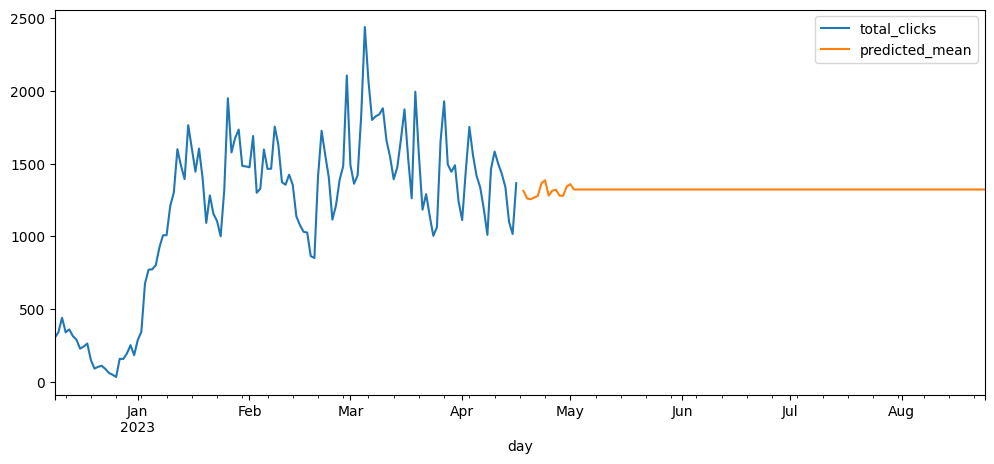

In [112]:
clicks_forecast = clicks_arima.forecast(len(test_df_minmax))
clicks_forecast = pd.DataFrame(clicks_forecast)

pipe_df_minmax['total_clicks'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
clicks_forecast['predicted_mean'][-129:].plot(legend=True);

## Facebook

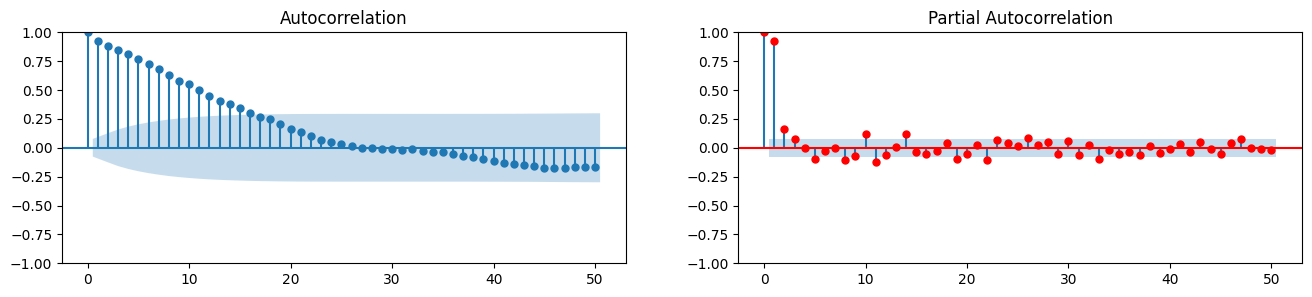

In [39]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(pipe_df_minmax['facebook'], lags=50, ax=axes[0]);
plot_pacf(pipe_df_minmax['facebook'], lags=50, ax=axes[1], color='r');

In [78]:
fb_model = pm.auto_arima(pipe_df_minmax['facebook'],
                       start_p=1, max_p=4,
                       start_q=13, max_q=19,
                       seasonal=False,
                       trend='t',
                       trace=True)

# ARIMA(1,0,13)(0,0,0)[0], AIC=-1647.126

Performing stepwise search to minimize aic
 ARIMA(1,0,13)(0,0,0)[0]             : AIC=-1647.126, Time=2.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-102.593, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1618.889, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-701.536, Time=0.17 sec
 ARIMA(0,0,13)(0,0,0)[0]             : AIC=-1538.124, Time=4.36 sec
 ARIMA(1,0,12)(0,0,0)[0]             : AIC=-1639.531, Time=1.91 sec
 ARIMA(2,0,13)(0,0,0)[0]             : AIC=-1646.620, Time=1.24 sec
 ARIMA(1,0,14)(0,0,0)[0]             : AIC=-1635.661, Time=2.58 sec
 ARIMA(0,0,12)(0,0,0)[0]             : AIC=33.293, Time=1.97 sec
 ARIMA(0,0,14)(0,0,0)[0]             : AIC=inf, Time=4.46 sec
 ARIMA(2,0,12)(0,0,0)[0]             : AIC=-1634.862, Time=1.27 sec
 ARIMA(2,0,14)(0,0,0)[0]             : AIC=-1631.107, Time=1.66 sec
 ARIMA(1,0,13)(0,0,0)[0] intercept   : AIC=-1647.126, Time=1.83 sec

Best model:  ARIMA(1,0,13)(0,0,0)[0] intercept
Total fit time: 23.730 seconds


In [107]:
fb_model = pm.auto_arima(pipe_df_minmax['facebook'],
                       start_p=1, max_p=4,
                       start_q=13, max_q=19,
                       seasonal=False,
                       trend='n',
                       trace=True)

# ARIMA(1,0,14)(0,0,0)[0], AIC=-1661.256

Performing stepwise search to minimize aic
 ARIMA(1,0,13)(0,0,0)[0]             : AIC=-1660.961, Time=2.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=401.885, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1611.176, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-281.261, Time=0.10 sec
 ARIMA(0,0,13)(0,0,0)[0]             : AIC=-1553.876, Time=2.50 sec
 ARIMA(1,0,12)(0,0,0)[0]             : AIC=-1653.858, Time=2.12 sec
 ARIMA(2,0,13)(0,0,0)[0]             : AIC=-1660.507, Time=2.30 sec
 ARIMA(1,0,14)(0,0,0)[0]             : AIC=-1661.256, Time=2.82 sec
 ARIMA(0,0,14)(0,0,0)[0]             : AIC=inf, Time=4.02 sec
 ARIMA(2,0,14)(0,0,0)[0]             : AIC=-1658.620, Time=3.42 sec
 ARIMA(1,0,15)(0,0,0)[0]             : AIC=-1659.685, Time=2.70 sec
 ARIMA(0,0,15)(0,0,0)[0]             : AIC=-1587.689, Time=3.54 sec
 ARIMA(2,0,15)(0,0,0)[0]             : AIC=-1658.745, Time=3.94 sec
 ARIMA(1,0,14)(0,0,0)[0] intercept   : AIC=-1661.256, Time=3.24 sec

Best model:  ARI

In [85]:
fb_model = pm.auto_arima(pipe_df_minmax['facebook'],
                       start_p=1, max_p=4,
                       start_q=13, max_q=19,
                       seasonal=False,
                       trend='c',
                       trace=True)

# ARIMA(1,0,14)(0,0,0)[0], AIC=-1672.605

Performing stepwise search to minimize aic
 ARIMA(1,0,13)(0,0,0)[0]             : AIC=-1671.488, Time=3.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-326.244, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1626.412, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-878.228, Time=0.05 sec
 ARIMA(0,0,13)(0,0,0)[0]             : AIC=-1653.955, Time=2.98 sec
 ARIMA(1,0,12)(0,0,0)[0]             : AIC=-1666.190, Time=2.51 sec
 ARIMA(2,0,13)(0,0,0)[0]             : AIC=-1671.337, Time=3.17 sec
 ARIMA(1,0,14)(0,0,0)[0]             : AIC=-1672.605, Time=3.41 sec
 ARIMA(0,0,14)(0,0,0)[0]             : AIC=-1573.667, Time=3.49 sec
 ARIMA(2,0,14)(0,0,0)[0]             : AIC=-1669.841, Time=3.46 sec
 ARIMA(1,0,15)(0,0,0)[0]             : AIC=-1671.766, Time=3.35 sec
 ARIMA(0,0,15)(0,0,0)[0]             : AIC=-1665.430, Time=3.27 sec
 ARIMA(2,0,15)(0,0,0)[0]             : AIC=-1670.699, Time=3.44 sec
 ARIMA(1,0,14)(0,0,0)[0] intercept   : AIC=-1672.605, Time=3.15 sec

Best mode

In [86]:
fb_model = pm.auto_arima(pipe_df_minmax['facebook'],
                       start_p=1, max_p=4,
                       start_q=13, max_q=19,
                       seasonal=False,
                       trend='ct',
                       trace=True)

# ARIMA(3,0,13)(0,0,0)[0], AIC=-1667.721

Performing stepwise search to minimize aic
 ARIMA(1,0,13)(0,0,0)[0]             : AIC=-1649.040, Time=1.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-328.914, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1624.676, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-868.573, Time=0.19 sec
 ARIMA(0,0,13)(0,0,0)[0]             : AIC=-110.901, Time=1.81 sec
 ARIMA(1,0,12)(0,0,0)[0]             : AIC=-1643.755, Time=1.08 sec
 ARIMA(2,0,13)(0,0,0)[0]             : AIC=-1648.688, Time=1.60 sec
 ARIMA(1,0,14)(0,0,0)[0]             : AIC=-1637.600, Time=1.24 sec
 ARIMA(0,0,12)(0,0,0)[0]             : AIC=inf, Time=2.61 sec
 ARIMA(0,0,14)(0,0,0)[0]             : AIC=inf, Time=3.08 sec
 ARIMA(2,0,12)(0,0,0)[0]             : AIC=-1657.676, Time=3.71 sec
 ARIMA(2,0,11)(0,0,0)[0]             : AIC=-1652.852, Time=1.51 sec
 ARIMA(3,0,12)(0,0,0)[0]             : AIC=-1646.463, Time=1.94 sec
 ARIMA(1,0,11)(0,0,0)[0]             : AIC=-1656.028, Time=1.51 sec
 ARIMA(3,0,11)(0,0,0)[0

In [113]:
from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

fb_arima = ARIMA(pipe_df_minmax['facebook'], order=(1,0,14), trend='c')
fb_arima = fb_arima.fit()
fb_arima.summary()

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               facebook   No. Observations:                  655
Model:                ARIMA(1, 0, 14)   Log Likelihood                 853.022
Date:                Wed, 06 Sep 2023   AIC                          -1672.043
Time:                        15:37:19   BIC                          -1595.805
Sample:                    07-01-2021   HQIC                         -1642.483
                         - 04-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2678      0.045      5.934      0.000       0.179       0.356
ar.L1          0.9018      0.052     17.344      0.000       0.800       1.004
ma.L1         -0.1279      0.057     -2.245      0.025      -0.239      -0.016
ma.L2          0.0160      0.054      0.299      0.765      -0.089       0.121
ma.L3          0.0623      0.048      1.294      0.196      -0.032       0.157
ma.L4          0.0905      0.047      1.906      0.057      -0.003       0.184
ma.L5          0.0464      0.049      0.947      0.344      -0.050       0.143
ma.L6          0.0770      0.048      1.620      0.105      -0.016       0.170
ma.L7          0.0988      0.044      2.255      0.024       0.013       0.185
ma.L8          0.0501      0.052      0.970      0.332      -0.051       0.151
ma.L9         -0.1156      0.052     -2.221      0.026      -0.218      -0.014
ma.L10         0.2281      0.045      5.094      0.000       0.140       0.316
ma.L11        -0.0863      0.043     -2.003      0.045      -0.171      -0.002
ma.L12         0.0066      0.037      0.179      0.858      -0.066       0.079
ma.L13        -0.1361      0.039     -3.507      0.000      -0.212      -0.060
ma.L14         0.0971      0.039      2.476      0.013       0.020       0.174
sigma2         0.0043      0.000     28.324      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2475.35
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
mm = MinMaxScaler()

test_df_minmax = test_df[['facebook', 'google', 'tiktok']]
test_df_minmax['facebook'] = mm.fit_transform(test_df_minmax[['facebook']])
test_df_minmax['google'] = mm.fit_transform(test_df_minmax[['google']])
test_df_minmax['tiktok'] = mm.fit_transform(test_df_minmax[['tiktok']])
test_df_minmax

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_4365/432568575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_minmax['facebook'] = mm.fit_transform(test_df_minmax[['facebook']])
/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_4365/432568575.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_minmax['google'] = mm.fit_transform(test_df_minmax[['google']])
/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_4365/432568575.py:6: SettingWithCopyWarning: 
A value

,facebook,google,tiktok
Day,,,
2023-04-17,0.308123,0.191324,0.486626
2023-04-18,0.344826,0.185894,0.462568
2023-04-19,0.353498,0.107421,0.625540
2023-04-20,0.297869,0.124552,0.666047
2023-04-21,0.255013,0.080851,0.611551
...,...,...,...
2023-08-20,0.970332,0.455110,0.839403
2023-08-21,1.000000,0.386604,0.903138
2023-08-22,0.578162,0.271230,0.409589


In [114]:
fb_forecast = fb_arima.forecast(len(test_df_minmax))
fb_forecast = pd.DataFrame(fb_forecast)

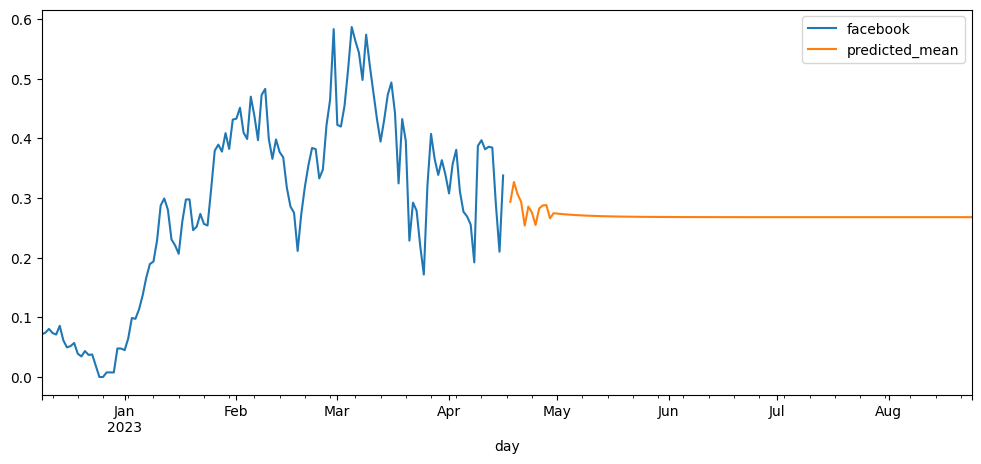

In [115]:
pipe_df_minmax['facebook'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
fb_forecast['predicted_mean'][-129:].plot(legend=True);

## Google

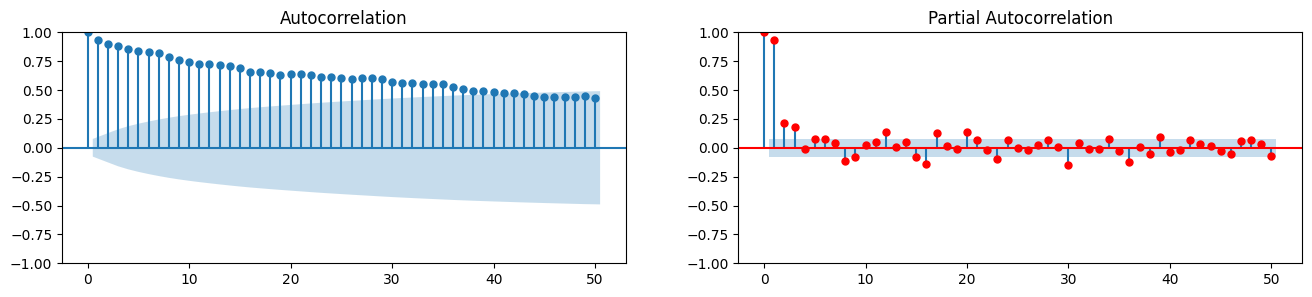

In [40]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(pipe_df_minmax['google'], lags=50, ax=axes[0]);
plot_pacf(pipe_df_minmax['google'], lags=50, ax=axes[1], color='r');

In [108]:
gg_model = pm.auto_arima(pipe_df_minmax['google'],
                       start_p=1, max_p=5,
                       start_q=35, max_q=45,
                       seasonal=True,
                       m = 7,
                       trend = 'n',
                       trace=True)
# ARIMA(0,1,4)(1,0,1)[7], AIC=-1802.409

Performing stepwise search to minimize aic
 ARIMA(1,1,6)(1,0,1)[7] intercept   : AIC=-1795.594, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1682.128, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1728.166, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1742.592, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1682.128, Time=0.02 sec
 ARIMA(1,1,6)(0,0,1)[7] intercept   : AIC=-1753.614, Time=1.62 sec
 ARIMA(1,1,6)(1,0,0)[7] intercept   : AIC=-1754.812, Time=1.13 sec
 ARIMA(1,1,6)(2,0,1)[7] intercept   : AIC=-1794.833, Time=2.49 sec
 ARIMA(1,1,6)(1,0,2)[7] intercept   : AIC=-1788.295, Time=3.78 sec
 ARIMA(1,1,6)(0,0,0)[7] intercept   : AIC=-1750.227, Time=0.68 sec
 ARIMA(1,1,6)(0,0,2)[7] intercept   : AIC=-1757.583, Time=2.40 sec
 ARIMA(1,1,6)(2,0,0)[7] intercept   : AIC=-1760.087, Time=1.53 sec
 ARIMA(1,1,6)(2,0,2)[7] intercept   : AIC=-1794.620, Time=4.56 sec
 ARIMA(0,1,6)(1,0,1)[7] intercept   : AIC=-1796.352, Time=1.69 sec
 ARIMA(0,1,6)(0,0,1

In [83]:
gg_model = pm.auto_arima(pipe_df_minmax['google'],
                       start_p=1, max_p=5,
                       start_q=35, max_q=45,
                       seasonal=True,
                       m = 7,
                       trend = 't',
                       trace=True)

# ARIMA(0,1,4)(2,0,1)[7], AIC=-1762.875

Performing stepwise search to minimize aic
 ARIMA(1,1,6)(1,0,1)[7] intercept   : AIC=-1749.376, Time=2.47 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1680.228, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1725.805, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1737.040, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1680.228, Time=0.08 sec
 ARIMA(1,1,6)(0,0,1)[7] intercept   : AIC=-1747.509, Time=1.80 sec
 ARIMA(1,1,6)(1,0,0)[7] intercept   : AIC=-1748.465, Time=1.26 sec
 ARIMA(1,1,6)(2,0,1)[7] intercept   : AIC=-1755.701, Time=2.37 sec
 ARIMA(1,1,6)(2,0,0)[7] intercept   : AIC=-1754.059, Time=2.03 sec
 ARIMA(1,1,6)(2,0,2)[7] intercept   : AIC=-1749.533, Time=4.17 sec
 ARIMA(1,1,6)(1,0,2)[7] intercept   : AIC=-1748.392, Time=3.67 sec
 ARIMA(0,1,6)(2,0,1)[7] intercept   : AIC=-1758.021, Time=2.10 sec
 ARIMA(0,1,6)(1,0,1)[7] intercept   : AIC=-1751.611, Time=2.01 sec
 ARIMA(0,1,6)(2,0,0)[7] intercept   : AIC=-1756.797, Time=2.23 sec
 ARIMA(0,1,6)(2,0,2

In [87]:
gg_model = pm.auto_arima(pipe_df_minmax['google'],
                       start_p=1, max_p=5,
                       start_q=35, max_q=45,
                       seasonal=True,
                       m = 7,
                       trend = 'c',
                       trace=True)

# ARIMA(1,1,6)(2,0,2)[7], AIC=-1786.260

Performing stepwise search to minimize aic
 ARIMA(1,1,6)(1,0,1)[7] intercept   : AIC=-1759.810, Time=3.42 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1680.205, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1726.239, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1740.708, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1680.205, Time=0.06 sec
 ARIMA(1,1,6)(0,0,1)[7] intercept   : AIC=-1751.866, Time=2.57 sec
 ARIMA(1,1,6)(1,0,0)[7] intercept   : AIC=-1753.182, Time=1.23 sec
 ARIMA(1,1,6)(2,0,1)[7] intercept   : AIC=-1766.743, Time=3.19 sec
 ARIMA(1,1,6)(2,0,0)[7] intercept   : AIC=-1758.319, Time=3.73 sec
 ARIMA(1,1,6)(2,0,2)[7] intercept   : AIC=-1786.260, Time=5.28 sec
 ARIMA(1,1,6)(1,0,2)[7] intercept   : AIC=-1762.882, Time=4.25 sec
 ARIMA(0,1,6)(2,0,2)[7] intercept   : AIC=-1777.876, Time=5.04 sec
 ARIMA(1,1,5)(2,0,2)[7] intercept   : AIC=-1775.429, Time=4.46 sec
 ARIMA(2,1,6)(2,0,2)[7] intercept   : AIC=-1773.122, Time=5.61 sec
 ARIMA(0,1,5)(2,0,2

In [88]:
gg_model = pm.auto_arima(pipe_df_minmax['google'],
                       start_p=1, max_p=5,
                       start_q=35, max_q=45,
                       seasonal=True,
                       m = 7,
                       trend = 'ct',
                       trace=True)

# ARIMA(0,1,4)(2,0,1)[7], AIC=-1760.862

Performing stepwise search to minimize aic
 ARIMA(1,1,6)(1,0,1)[7] intercept   : AIC=-1747.375, Time=2.74 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1678.228, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1723.807, Time=0.59 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1735.043, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1678.228, Time=0.07 sec
 ARIMA(1,1,6)(0,0,1)[7] intercept   : AIC=-1745.513, Time=2.16 sec
 ARIMA(1,1,6)(1,0,0)[7] intercept   : AIC=-1746.471, Time=1.08 sec
 ARIMA(1,1,6)(2,0,1)[7] intercept   : AIC=-1753.701, Time=2.15 sec
 ARIMA(1,1,6)(2,0,0)[7] intercept   : AIC=-1752.065, Time=2.03 sec
 ARIMA(1,1,6)(2,0,2)[7] intercept   : AIC=-1747.510, Time=4.19 sec
 ARIMA(1,1,6)(1,0,2)[7] intercept   : AIC=-1746.384, Time=4.26 sec
 ARIMA(0,1,6)(2,0,1)[7] intercept   : AIC=-1756.020, Time=2.52 sec
 ARIMA(0,1,6)(1,0,1)[7] intercept   : AIC=-1749.610, Time=2.33 sec
 ARIMA(0,1,6)(2,0,0)[7] intercept   : AIC=-1754.803, Time=2.46 sec
 ARIMA(0,1,6)(2,0,2

In [118]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

gg_sarimax = SARIMAX(pipe_df_minmax['google'], order=(0,1,4), seasonal_order=(1,0,1,7), trend='n')
gg_sarimax = gg_sarimax.fit()
gg_sarimax.summary()

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35098D+00    |proj g|=  6.93347D-01

At iterate    5    f= -1.35324D+00    |proj g|=  8.92463D-01

At iterate   10    f= -1.35582D+00    |proj g|=  1.95220D-01

At iterate   15    f= -1.35631D+00    |proj g|=  1.39634D-01

At iterate   20    f= -1.35734D+00    |proj g|=  9.25794D-02

At iterate   25    f= -1.36190D+00    |proj g|=  6.63551D-02

At iterate   30    f= -1.37833D+00    |proj g|=  1.04332D-01

At iterate   35    f= -1.37907D+00    |proj g|=  3.53234D-01

At iterate   40    f= -1.38575D+00    |proj g|=  1.41143D-01

At iterate   45    f= -1.38619D+00    |proj g|=  1.59986D-01

At iterate   50    f= -1.38657D+00    |proj g|=  3.31626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              google   No. Observations:                  655
Model:             SARIMAX(0, 1, 4)x(1, 0, [1], 7)   Log Likelihood                 908.204
Date:                             Wed, 06 Sep 2023   AIC                          -1802.409
Time:                                     15:38:48   BIC                          -1771.027
Sample:                                 07-01-2021   HQIC                         -1790.240
                                      - 04-16-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3270      0.021    -15.629      0.000      -0.368      -0.286
ma.L2         -0.0735      0.021     -3.515      0.000      -0.115      -0.033
ma.L3          0.0747      0.024      3.139      0.002       0.028       0.121
ma.L4         -0.1081      0.025     -4.296      0.000      -0.157      -0.059
ar.S.L7        0.9828      0.017     58.045      0.000       0.950       1.016
ma.S.L7       -0.9294      0.027    -34.334      0.000      -0.982      -0.876
sigma2         0.0036   9.14e-05     39.564      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4108.63
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):             852.64   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

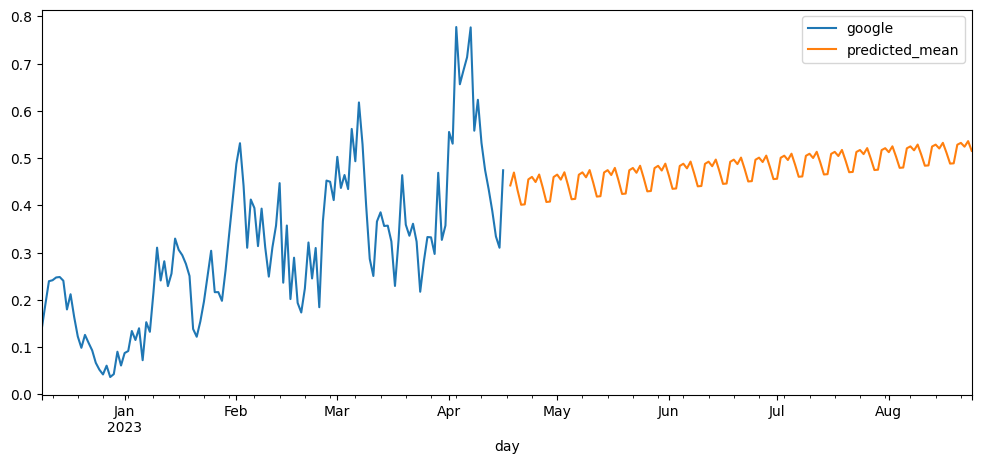

In [119]:
gg_forecast = gg_sarimax.forecast(len(test_df_minmax))
gg_forecast = pd.DataFrame(gg_forecast)

pipe_df_minmax['google'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
gg_forecast['predicted_mean'][-129:].plot(legend=True);

## Tiktok

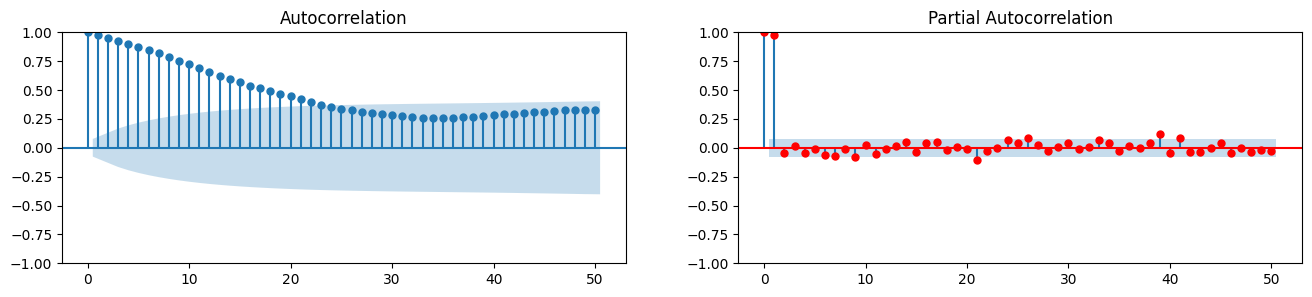

In [41]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(pipe_df_minmax['tiktok'], lags=50, ax=axes[0]);
plot_pacf(pipe_df_minmax['tiktok'], lags=50, ax=axes[1], color='r');

In [109]:

tt_model = pm.auto_arima(pipe_df_minmax['tiktok'],
                       start_p=1, max_p=3,
                       start_q=20, max_q=27,
                       seasonal=False,
                       trend = 'n',
                       trace=True)
# ARIMA(0,1,0)(0,0,0)[0], AIC=-2134.959

Performing stepwise search to minimize aic
 ARIMA(1,1,20)(0,0,0)[0] intercept   : AIC=-2123.446, Time=5.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2134.959, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2133.649, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2133.690, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2134.959, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.683 seconds


In [47]:
tt_model = pm.auto_arima(pipe_df_minmax['tiktok'],
                       start_p=1, max_p=3,
                       start_q=20, max_q=27,
                       seasonal=False,
                       trend = 't',
                       trace=True)

# ARIMA(0,1,0)(0,0,0)[0], AIC=-2134.959

Performing stepwise search to minimize aic
 ARIMA(1,1,20)(0,0,0)[0] intercept   : AIC=-2120.776, Time=7.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2133.015, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2131.702, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2131.742, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2134.959, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.987 seconds


In [89]:
tt_model = pm.auto_arima(pipe_df_minmax['tiktok'],
                       start_p=1, max_p=3,
                       start_q=20, max_q=27,
                       seasonal=False,
                       trend = 'c',
                       trace=True)

# ARIMA(0,1,0)(0,0,0)[0], AIC=-2133.015

Performing stepwise search to minimize aic
 ARIMA(1,1,20)(0,0,0)[0] intercept   : AIC=-2120.776, Time=9.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2133.015, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2131.702, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2131.742, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2133.015, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 9.877 seconds


In [90]:
tt_model = pm.auto_arima(pipe_df_minmax['tiktok'],
                       start_p=1, max_p=3,
                       start_q=20, max_q=27,
                       seasonal=False,
                       trend = 'ct',
                       trace=True)

# ARIMA(0,1,0)(0,0,0)[0], AIC=-2131.074

Performing stepwise search to minimize aic
 ARIMA(1,1,20)(0,0,0)[0] intercept   : AIC=-2109.863, Time=2.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2131.074, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2129.757, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2129.786, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2131.074, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1440.733, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.938 seconds


/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [95]:
tt_arima = ARIMA(pipe_df_minmax['tiktok'], order=(0, 1, 0), trend='t')
tt_arima = tt_arima.fit()
tt_arima.summary()

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 tiktok   No. Observations:                  655
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1068.507
Date:                Wed, 06 Sep 2023   AIC                          -2133.015
Time:                        15:25:16   BIC                          -2124.048
Sample:                    07-01-2021   HQIC                         -2129.538
                         - 04-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004      0.002      0.232      0.816      -0.003       0.004
sigma2         0.0022   5.74e-05     38.855      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):              1473.12
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               5.82   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

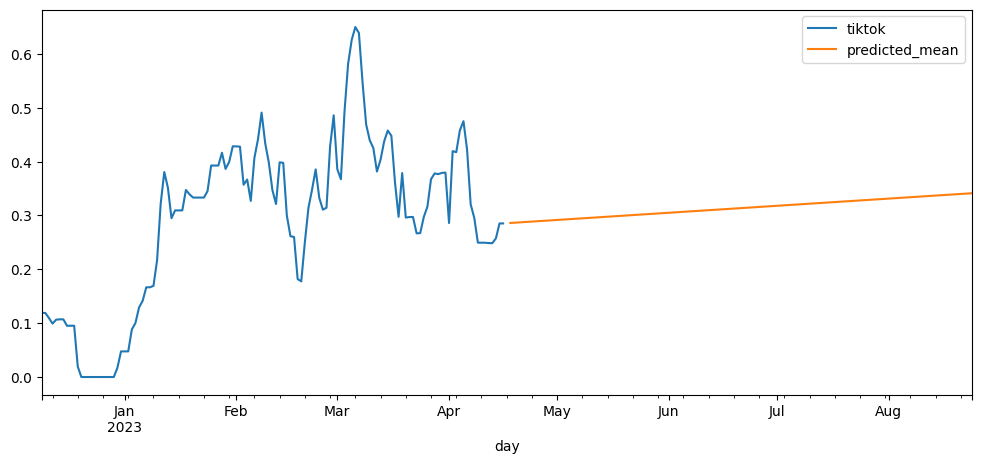

In [97]:
tt_forecast = tt_arima.forecast(len(test_df_minmax))
tt_forecast = pd.DataFrame(tt_forecast)

pipe_df_minmax['tiktok'][-129:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
tt_forecast['predicted_mean'][-129:].plot(legend=True);